In [47]:
import pandas as pd

In [48]:
gamestates = pd.read_parquet("./gamestates_final.parquet")

gamestates = gamestates.drop(columns=["match_id", "event_id", "team_id"])

In [49]:
gamestates

,action_1,start_x_1,start_y_1,end_x_1,end_y_1,start_x,start_y,end_x,end_y,cross_success,...,num_attackers_near_action_line,num_defenders_near_action_line,cross_region,polar_angle_entry,polar_angle_cross,signed_angle_cross_from_y,distance_start_from_goal,distance_from_end_line,box_ratio,zone_ratio
0,PASS,29.518,19.635,43.205,27.236,43.205,27.236,46.140,-11.708,1,...,1.0,5.0,segundo_pau,0.506937,-1.495574,-3.066370,28.749465,9.295,0.500000,0.999999
1,PASS,27.271,24.053,34.653,28.309,36.659,26.102,41.995,4.524,0,...,1.0,1.0,primeiro_pau,0.214887,-1.328371,-2.899167,26.237086,15.841,0.428571,0.000000
2,PASS,28.903,10.279,34.911,22.386,40.355,20.863,47.882,-7.707,1,...,1.0,3.0,segundo_pau,0.746028,-1.313192,-2.883988,21.809420,12.145,0.300000,1000000.000000
13,PASS,26.772,16.755,37.811,24.854,41.005,21.388,47.707,-7.719,1,...,0.0,3.0,segundo_pau,0.314694,-1.344487,-2.915283,22.505923,11.495,0.500000,0.500000
25,PASS,23.205,23.209,35.884,22.942,36.868,21.410,45.218,2.658,0,...,1.0,1.0,area,-0.130916,-1.151870,-2.722666,21.601239,15.632,0.600000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7587,PASS,31.125,26.484,44.651,25.630,44.651,25.630,43.835,-4.374,0,...,0.0,1.0,segundo_pau,-0.063054,-1.597986,3.114403,27.755012,7.849,0.200000,0.000000
7589,PASS,23.312,20.000,35.812,25.722,35.566,25.868,46.633,1.387,0,...,0.0,0.0,area,0.446596,-1.146227,-2.717023,25.915358,16.934,0.200000,0.000000
7591,PASS,15.053,6.707,27.844,27.153,30.325,28.854,40.546,9.774,0,...,1.0,1.0,primeiro_pau,0.967102,-1.079005,-2.649801,29.087092,22.175,0.250000,0.000000
7594,CLEARANCE,45.695,1.098,45.695,1.098,38.450,29.631,35.889,-0.073,0,...,1.0,0.0,area,1.819458,-1.656801,3.055588,29.963289,14.050,0.555555,0.000000


In [50]:
print("Colunas do Gamestates:")
for col in gamestates.columns:
    print("\t - " + col)

Colunas do Gamestates:
	 - action_1
	 - start_x_1
	 - start_y_1
	 - end_x_1
	 - end_y_1
	 - start_x
	 - start_y
	 - end_x
	 - end_y
	 - cross_success
	 - attackers_in_box
	 - defenders_in_box
	 - attackers_in_zone
	 - defenders_in_zone
	 - entropy_general
	 - entropy_diff
	 - pitch_control_at_target
	 - num_attackers_near_action_line
	 - num_defenders_near_action_line
	 - cross_region
	 - polar_angle_entry
	 - polar_angle_cross
	 - signed_angle_cross_from_y
	 - distance_start_from_goal
	 - distance_from_end_line
	 - box_ratio
	 - zone_ratio


In [51]:
X = gamestates.drop(columns=["cross_success"])
X = pd.get_dummies(X, columns=['action_1', 'cross_region'])

y = gamestates["cross_success"]

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

# Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 2. Pipeline de modelo + seleção de features ===
base_model = XGBClassifier(
    eval_metric="logloss",
    random_state=42
)

rfecv = RFECV(
    estimator=base_model,
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1',
    n_jobs=-1
)

pipeline = Pipeline([
    ('feature_selection', rfecv),
    ('classifier', base_model)
])

# === 3. Grid Search nos hiperparâmetros ===
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(5),
    verbose=1,
    n_jobs=-1
)

# === 4. Treinar ===
grid_search.fit(X_train, y_train)

# Melhor modelo treinado
best_model = grid_search.best_estimator_

# === 5. Avaliação ===
y_pred = best_model.predict(X_test)
print("F1 no conjunto de teste:", f1_score(y_test, y_pred))

# Features selecionadas
selected_features = X_train.columns[best_model.named_steps['feature_selection'].support_]
print("Features selecionadas:", list(selected_features))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
F1 no conjunto de teste: 0.42786069651741293
Features selecionadas: ['start_y_1', 'end_x_1', 'start_x', 'end_x', 'end_y', 'defenders_in_box', 'defenders_in_zone', 'entropy_general', 'entropy_diff', 'pitch_control_at_target', 'num_defenders_near_action_line', 'polar_angle_cross', 'zone_ratio']


In [55]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Use o X_test completo — o pipeline se encarrega da seleção
y_pred = best_model.predict(X_test)

# Métricas
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-score (positivo): {f1_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Acurácia: 0.7681
F1-score (positivo): 0.4279
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       367
           1       0.60      0.33      0.43       129

    accuracy                           0.77       496
   macro avg       0.70      0.63      0.64       496
weighted avg       0.75      0.77      0.74       496



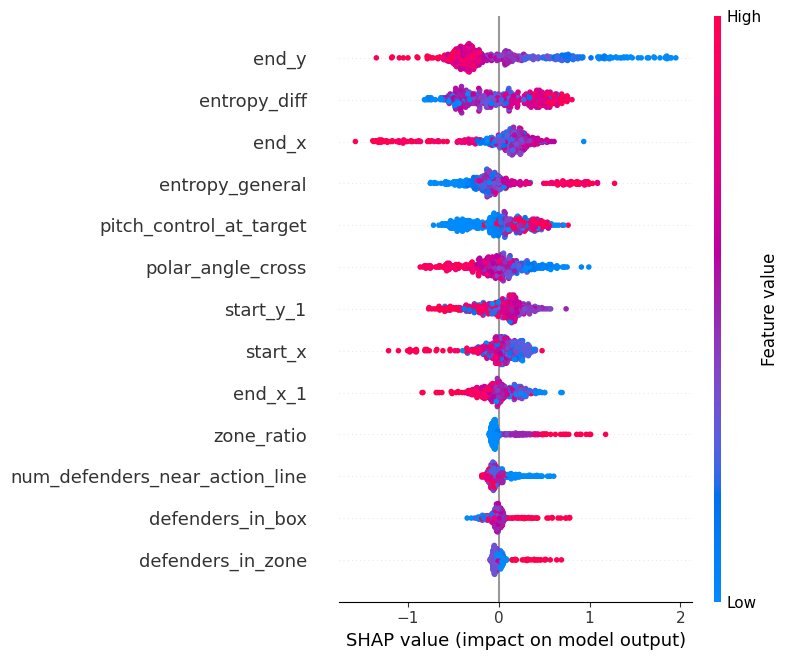

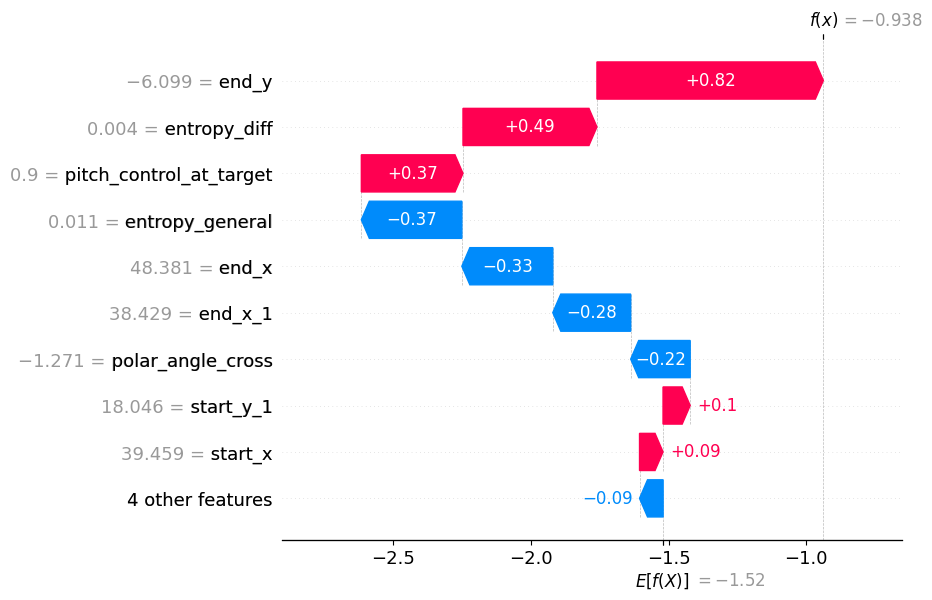

In [53]:
# Modelo final XGBoost com features reduzidas
final_xgb = best_model.named_steps["classifier"]
X_test_reduced = X_test[selected_features]

# === 6. SHAP Explainer ===
explainer = shap.Explainer(final_xgb, X_test_reduced)
shap_values = explainer(X_test_reduced)

# === 7. Gráfico de importância global ===
shap.summary_plot(shap_values, X_test_reduced)

# === 8. Gráfico de uma predição específica (opcional) ===
shap.plots.waterfall(shap_values[0])  # Explica o primeiro exemplo de teste

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve

y_proba = best_model.predict_proba(X_test)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

f1s = 2 * prec * rec / (prec + rec)
best_idx = f1s.argmax()

threshold = 0.45

print(f"Melhor threshold para F1: {thresholds[best_idx]:.2f}")
print(f"F1 correspondente: {f1s[best_idx]:.4f}")


Melhor threshold para F1: 0.26
F1 correspondente: 0.5678


In [99]:
import numpy as np

y_pred_thresh = (y_proba >= threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, f1_score

print(f"Classification Report com threshold = {threshold}:")
print(classification_report(y_test, y_pred_thresh))

Classification Report com threshold = 0.44:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       367
           1       0.56      0.40      0.47       129

    accuracy                           0.76       496
   macro avg       0.68      0.65      0.66       496
weighted avg       0.74      0.76      0.75       496



Total de falsos negativos: 86


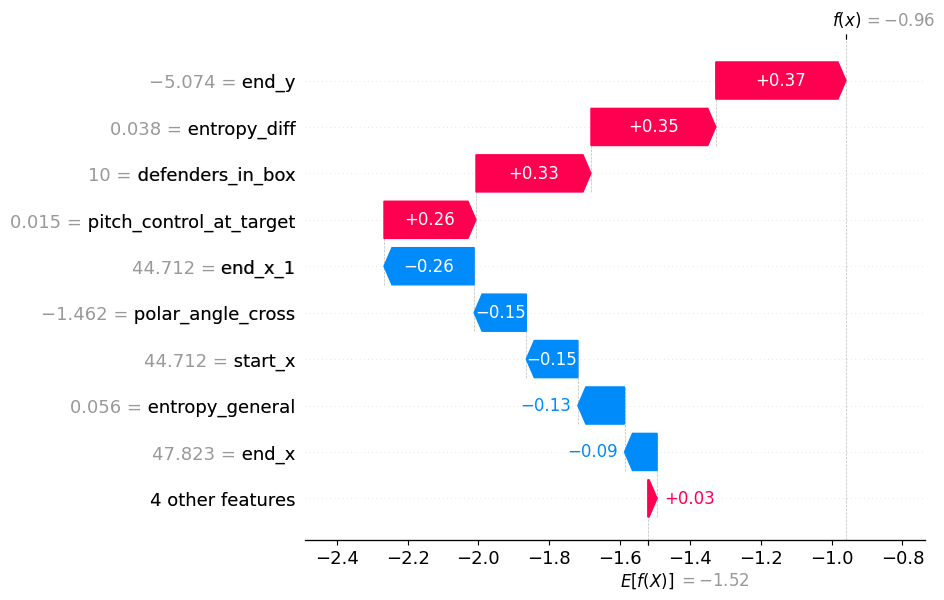

In [56]:
import numpy as np
import shap

# === 1. Prever com o modelo final ===
y_pred = best_model.predict(X_test)

# === 2. Encontrar os falsos negativos ===
false_negatives_mask = (y_test == 1) & (y_pred == 0)
false_negatives_idx = np.where(false_negatives_mask)[0]

print(f"Total de falsos negativos: {len(false_negatives_idx)}")

# === 3. Extrair os dados com as features selecionadas ===
selected_features = X_test.columns[best_model.named_steps['feature_selection'].support_]
X_test_reduced = X_test[selected_features]

X_fn = X_test_reduced.iloc[false_negatives_idx]

# === 4. Criar explainer SHAP para o modelo final ===
final_model = best_model.named_steps['classifier']
explainer = shap.Explainer(final_model, X_test_reduced)

# === 5. Gerar valores SHAP apenas para os falsos negativos ===
shap_values_fn = explainer(X_fn)

# === 6. Visualizar os principais falsos negativos ===
# Exemplo: plota explicação do primeiro falso negativo
shap.plots.waterfall(shap_values_fn[0])

# Dica: repetir para outros
# for i in range(min(5, len(false_negatives_idx))):
#     shap.plots.waterfall(shap_values_fn[i])


In [34]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


model = XGBClassifier(random_state=42)

# Espaço de busca (você pode ajustar conforme o tamanho do seu dataset)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',        # ou 'roc_auc', 'f1', etc.
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Treina o grid
grid_search.fit(X_train, y_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Melhor modelo já treinado com esses parâmetros
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Melhores parâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


In [24]:
y_pred = best_model.predict(X_test)

Acurácia: 0.74
              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1487
           1       0.47      0.33      0.39       496

    accuracy                           0.74      1983
   macro avg       0.63      0.60      0.61      1983
weighted avg       0.72      0.74      0.72      1983

Axes(0.125,0.11;0.775x0.77)


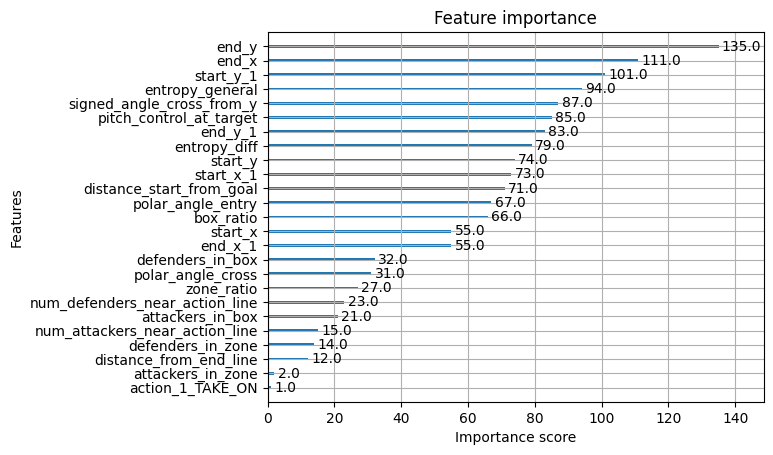

In [25]:
from sklearn.metrics import accuracy_score, classification_report
from xgboost import plot_importance


accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

classification = classification_report(y_test, y_pred)
print(classification)

print(plot_importance(best_model))

In [27]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42, eval_metric='logloss')

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

# Features selecionadas
selected_features = X_train.columns[rfecv.support_]
print("Features selecionadas:", list(selected_features))

# Novo dataset reduzido
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


Features selecionadas: ['start_x_1', 'start_y_1', 'end_x_1', 'start_x', 'end_x', 'end_y', 'attackers_in_box', 'defenders_in_box', 'entropy_general', 'entropy_diff', 'pitch_control_at_target', 'num_defenders_near_action_line', 'polar_angle_cross', 'signed_angle_cross_from_y', 'zone_ratio']


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

# Modelo base
base_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Wrapper RFECV
rfecv = RFECV(
    estimator=base_model,
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1_macro',
    n_jobs=-1
)

# Pipeline com RFECV + Classificador
pipeline = Pipeline([
    ('feature_selection', rfecv),
    ('classifier', base_model)
])

# Grid de parâmetros (do classificador)
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=StratifiedKFold(5),
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Melhor score e parâmetros
print("Melhor F1:", grid_search.best_score_)
print("Melhores parâmetros:", grid_search.best_params_)

# Features selecionadas
selected_features = X_train.columns[grid_search.best_estimator_['feature_selection'].support_]
print("Features selecionadas:", list(selected_features))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


Melhor F1: 0.6128684789956775
Melhores parâmetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Features selecionadas: ['start_x_1', 'start_y_1', 'end_x_1', 'start_x', 'end_x', 'end_y', 'attackers_in_box', 'defenders_in_box', 'entropy_general', 'entropy_diff', 'pitch_control_at_target', 'num_defenders_near_action_line', 'polar_angle_cross', 'signed_angle_cross_from_y', 'zone_ratio']


Acurácia: 0.77
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       368
           1       0.62      0.33      0.43       128

    accuracy                           0.77       496
   macro avg       0.71      0.63      0.64       496
weighted avg       0.75      0.77      0.75       496

Axes(0.125,0.11;0.775x0.77)


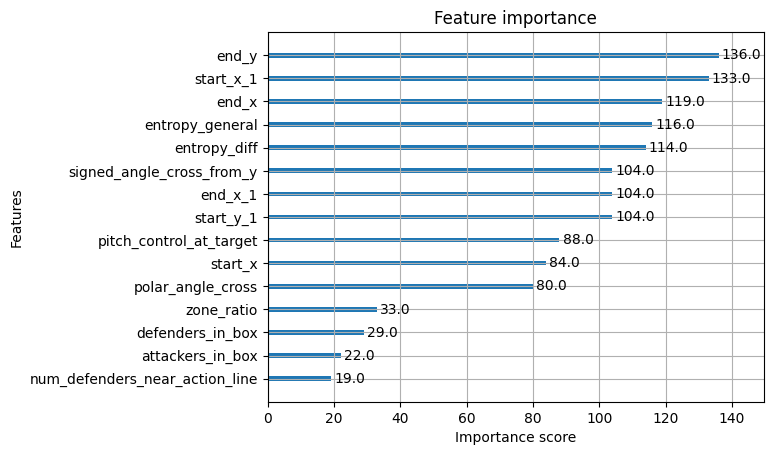

In [40]:
features = ['start_x_1', 'start_y_1', 'end_x_1', 'start_x', 'end_x', 'end_y', 'attackers_in_box', 'defenders_in_box', 'entropy_general', 'entropy_diff', 'pitch_control_at_target', 'num_defenders_near_action_line', 'polar_angle_cross', 'signed_angle_cross_from_y', 'zone_ratio']

from sklearn.metrics import accuracy_score, classification_report
from xgboost import plot_importance

X_test = X_test[features]
X_train_selected = X_train[['start_x_1', 'start_y_1', 'end_x_1', 'start_x', 'end_x', 'end_y', 'attackers_in_box', 'defenders_in_box', 'entropy_general', 'entropy_diff', 'pitch_control_at_target', 'num_defenders_near_action_line', 'polar_angle_cross', 'signed_angle_cross_from_y', 'zone_ratio']]

model = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
)

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

classification = classification_report(y_test, y_pred)
print(classification)

print(plot_importance(model))